In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

import scipy.linalg as la
import numpy.random as rnd

# shapely and descartes must be installed separately.
from shapely.geometry import Point, Polygon, LineString
import shapely.ops as ops
import descartes

# This is Andy's hand-cooked kernel module. 
# Probably better to replace with something like GPy.
import kernels as kn
reload(kn)
%matplotlib inline

In [2]:
# These are some helper functions
def inequalityMatrices(verts):
    """
    Convert a polygon stored as a collection of vertices (assuming listed in order)
    to a constraint of the form
    Ax <= B
    """
    
    n = len(verts)
    
    A = np.zeros((n,2))
    b = np.zeros(n)
    
    for k in range(n):
        M = np.hstack((np.zeros((2,2)),np.ones((2,1))))
        M[0,:2] = verts[k]
        M[1,:2] = verts[(k+1) % n]
        U,S,Vh = la.svd(M)
        V2 = Vh[-1]
        vec = np.hstack((verts[(k+2) % n],1))
        sgn = 1. if np.dot(V2,vec) < 0 else -1.
        A[k,:] = sgn * V2[:2]
        b[k] = -sgn * V2[-1]
        
    return A,b
    
    

def isCollision(g,constraintList):
    x = g[:2]
    for  A,b in constraintList:
        res = b - np.dot(A,x)
        if res.min() >= 0:
            return True
    return False

def rangeFinderValue(g,constraintList):
    """
    Given g = (x,y,theta), this finds the point on the nearest polygon that the laser range-finder would hit.
    
    """
    x = g[:2]
    theta = g[-1]
    TList = np.zeros(len(constraintList))
    for k in range(len(constraintList)):
        A,b = constraintList[k]
        a = np.dot(A,np.array([np.cos(theta),np.sin(theta)]))
        bCur = b - np.dot(A,x)
        NegInd = a < 0
        PosInd = a >= 0
        
        # This will have issues if the beam is exactly parallel to an edge
        
        tLow = np.max(bCur[NegInd]/a[NegInd])
        tHigh = np.min(bCur[PosInd]/a[PosInd])
        
        t = tLow if (tLow <= tHigh) and (tLow >=0) else np.inf
        
        TList[k] = t
        
        d = TList.min()
        
    return d


def carPolygon(g):
    cL = 2.
    cW = 1.
    
    x = g[:2]
    theta = g[-1]
    
    R = np.array([[np.cos(theta),-np.sin(theta)],
                  [np.sin(theta),np.cos(theta)]])
    
    carPoly = np.array([[-cL/2,-cW/2],
                        [cL/2,0],
                        [-cL/2,cW/2]])
    
    carPoly = np.dot(carPoly,R.T) + np.outer(np.ones(3),x)
    
    return Polygon(carPoly)
    
    
    
        
    

In the code below, we will be generating a square environment, with obstacles represented by polygons.

Every polygon can be represented as a set:
\begin{equation*}
P = \{x : Ax \le b\},
\end{equation*}
where the inequality $Ax\le b$ is interpreted element-wise. Here $A$ is an $d\times 2$ matrix, where $d$ is the number of faces of the polygon.

The walls of the environment are fixed, and the obstacles inside the environment are randomly generated polynomials.

(-8.0, 8.0, -8.0, 8.0)

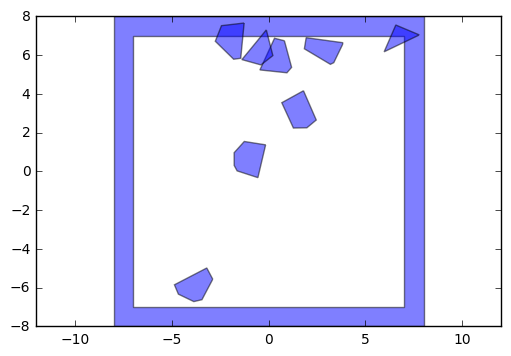

In [3]:
# Assume that vertices are enumerated counter-clockwise
# Build the constraints
leftPoly = [[-8,-8],[-7,-8],[-7,8],[-8,8]]
botPoly = [[-7,-8],[7,-8],[7,-7],[-7,-7]]
rightPoly = [[7,-8],[8,-8],[8,8],[7,8]]
topPoly = [[-7,7],[7,7],[7,8],[-7,8]]

# Number of obstacles
NumObs = 8


obsPoly = []

for obs in range(NumObs):
    NumVert = rnd.randint(3,8)
    Cen = 14. * rnd.rand(2) - 7.
    Theta = np.sort(2*np.pi * rnd.rand(NumVert))
    d  = rnd.rand(NumVert)
    obsVert = np.outer(np.ones(NumVert),Cen) +  np.vstack((np.cos(Theta),np.sin(Theta))).T
    obsPoly.append(obsVert)
    


shapeVerticesList = [leftPoly,botPoly,rightPoly,topPoly]



polyList = [Polygon(verts) for verts in shapeVerticesList]

polyUnion = ops.unary_union(polyList)


fig = plt.figure()
ax = fig.add_subplot(111)

ax.add_patch(descartes.PolygonPatch(polyUnion,fc = 'blue',alpha=0.5))

obsList = [Polygon(verts) for verts in obsPoly]
obsUnion = ops.unary_union(obsList)

for obs in obsList:
    ax.add_patch(descartes.PolygonPatch(obs,fc = 'blue',alpha=0.5))


constraintList = [inequalityMatrices(verts) for verts in shapeVerticesList+obsPoly]

ax.axis('equal')

Below is a test of the laser range-finder. The robot is placed randomly in the environment (it may be placed inside an obstacle), and the laser is shot.

In [ ]:

x = 10 * rnd.rand(2) - 5.
theta = 2*np.pi * rnd.rand()


g = np.hstack((x,theta))
t = rangeFinderValue(g,constraintList)

xInt = x + t*np.array([np.cos(theta),np.sin(theta)])

carPoly = carPolygon(g)

fig = plt.figure()
ax = fig.add_subplot(111)


plt.plot([x[0],xInt[0]],[x[1],xInt[1]],'r')
plt.plot(xInt[0],xInt[1],'r*')

ax.add_patch(descartes.PolygonPatch(carPoly,fc='orange'))
ax.add_patch(descartes.PolygonPatch(polyUnion,fc = 'blue',alpha=0.5))

for obs in obsList:
    ax.add_patch(descartes.PolygonPatch(obs,fc = 'blue',alpha=0.5))

ax.axis('equal')

Below is the mapping. Here the robot is placed in several random locations. It is assumed that the robot is perfectly localized. In other words, it knows its $x$, $y$, and $\theta$ values. From each random location, the laser is fired. 

When a laser is fired from pose $g = (x,y,\theta)$, and it sees an obstacle of distance $d$, there must by an obstacle at location:
\begin{equation*}
\begin{bmatrix}
x_O \\
y_O
\end{bmatrix}
=
\begin{bmatrix}
x \\
y
\end{bmatrix}
+ d \begin{bmatrix}
\cos\theta \\
\sin\theta
\end{bmatrix}
\end{equation*}
and furthermore, there can be no obstacles along the line between $(x,y)$ and $(x_O,y_O)$. 

The obstacles are represented probabilistically as the following set:
\begin{equation*}
\mathcal{O} = \{(x,y):f(x,y) =0\},
\end{equation*}
where $f(x)$ is a Gaussian process.

So, for each range-finder measurement, we record a value $f(x_O,y_O)=0$, and then we record a few other values $f(x',y')<0$ along the line between $(x,y)$ and $(x_O,y_O)$. 

For unknown values, the presence of an obstacle is inferred using GP regression.

In [ ]:
thetaWall = 1.
NumSamp = 50

gk = kn.mvGaussian(theta=.1)

x = np.zeros(2)
Theta = 2. * np.pi * rnd.rand(NumSamp)

SampPerBeam = 6

XList = []
YList= []



D = np.zeros(NumSamp)
for k in range(NumSamp):
    x = 14 * rnd.rand(2) - 7.
    theta = Theta[k]
    g = np.hstack((x,theta))
    d = rangeFinderValue(g,constraintList)
        
    D[k] = d
    if (d > 1e-3) and (not isCollision(g,constraintList)):
        XSamp = np.zeros((SampPerBeam,2))
        u = np.array([np.cos(theta),np.sin(theta)])
        dVec = np.zeros(SampPerBeam)
        dVec[0:2] = [d,0]
        if SampPerBeam > 2:
            dVec[2:] = d * rnd.rand(SampPerBeam-2)
            

        for samp in range(SampPerBeam):
            XSamp[samp] = x + dVec[samp] * u
        
        YSamp = np.tanh(-thetaWall * (d-dVec))
        XList.append(XSamp)
        YList.append(YSamp)
        
    if d < 0:
        print 'Inside'
        

X = np.vstack(XList)
Y = np.hstack(YList)

K = gk.k(X,X)+1e-8 * np.eye(len(X))
Emat = la.solve(K,Y,sym_pos=True)

X1Grid,X2Grid = np.meshgrid(np.linspace(-8,8,100),np.linspace(-8,8,100))

XGrid = np.vstack((X1Grid.flatten(),X2Grid.flatten())).T

kGrid = gk.k(XGrid,X)

YGrid = np.dot(kGrid,Emat).reshape(X1Grid.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.contour(X1Grid,X2Grid,YGrid,[0],linewidths=2)
# ax.plot(X[:,0],X[:,1],'g.',alpha=.1)

for xl in XList:
    plt.plot(xl[:2,0],xl[:2,1],'k',alpha=.3)
    plt.plot(xl[0,0],xl[0,1],'r*',alpha=.3)
    plt.plot(xl[1,0],xl[1,1],'go',alpha=.3)
    
ax.add_patch(descartes.PolygonPatch(polyUnion,fc = 'red',alpha=0.1))

for obs in obsList:
    ax.add_patch(descartes.PolygonPatch(obs,fc = 'red',alpha=0.1))

ax.set_xticks([])
ax.set_yticks([])
ax.axis('equal')
plt.savefig('gpMap.pdf',bbox_inches='tight',transparent=True)